In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from torchvision import transforms

In [3]:
# process the data
# take percent for example

folder = "../gyy_test/"# WCET
data = np.zeros(10, dtype=float)
label = np.zeros(1, dtype=float)

for id in range(5):# 5
    filename = "random_4_0.1_1.0_" + str(id) + ".txt"
    new_data = np.genfromtxt(folder + filename)
    data = np.vstack([data, new_data[:, 0:20:2]])
    label = np.hstack([label, new_data[:, -1]])

data = data[1:, :]
#data = data[:, [2, 3, 6, 7, 8, 9]]
label = label[1:]

In [12]:
data.shape

(2950265, 6)

In [4]:
'''设置超参数'''
feature_number = 10  # 设置特征数目
out_prediction = 1  # 设置输出数目
learning_rate = 0.001  # 设置学习率
epochs = 50  # 设置训练代数
batch_size = 64

In [5]:
# 划分数据集
from sklearn.model_selection import train_test_split
 
train_x, val_test_x, train_y, val_test_y = train_test_split(data, label, train_size=0.98,test_size=0.02,
                                                 random_state=2023, shuffle=True)
val_x, test_x, val_y, test_y = train_test_split(val_test_x, val_test_y, train_size=0.5, test_size=0.5,
                                                     random_state=2023, shuffle=True)

In [6]:
'''mean_X, std_X = train_x.mean(axis=0), train_x.std(axis=0)
mean_Y, std_Y = train_y.mean(), train_y.std()'''

# normalize the train data
from sklearn.preprocessing import StandardScaler
 
scaler1 = StandardScaler()  # 实例化
scaler2 = StandardScaler()
X = scaler1.fit_transform(train_x)  # 标准化特征
Y = scaler2.fit_transform(train_y.reshape(-1, 1))  # 标准化标签

pickle.dump(scaler1, open('scaler_x_new_add.pkl','wb'))
pickle.dump(scaler2, open('scaler_y_new_add.pkl','wb'))

 
# x = scaler.inverse_transform(X) # 这行代码可以将数据恢复至标准化之前

In [7]:
train_x = scaler1.transform(train_x)
val_x = scaler1.transform(val_x)
test_x = scaler1.transform(test_x)

train_y = scaler2.transform(train_y.reshape(-1, 1))
val_y = scaler2.transform(val_y.reshape(-1, 1))
# test_y = scaler2.transform(test_y)

In [8]:
# transform the data type

train_x, val_x, test_x = torch.from_numpy(train_x), torch.from_numpy(val_x), torch.from_numpy(test_x)
train_y, val_y, test_y = torch.from_numpy(train_y), torch.from_numpy(val_y), torch.from_numpy(test_y)

In [9]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)
validation = torch.utils.data.TensorDataset(val_x, val_y)

'''# 划分训练集测试集与验证集
torch.manual_seed(seed=2023) # 设置随机种子分关键，不然每次划分的数据集都不一样，不利于结果复现
# 大概是98：1：1的比例划分
train_validaion, test = torch.utils.data.random_split(
    torch_dataset,
    [2891000, 59265],
)  # 先将数据集拆分为训练集+验证集
train, validation = torch.utils.data.random_split(
    train_validaion, [2830000, 61000])  # 再将训练集+验证集拆分为训练集，测试集'''
 
# 将训练集划分批次，每batch_size个数据一批（测试集与验证集不划分批次）
train_data = torch.utils.data.DataLoader(train,
                                         batch_size=batch_size,
                                         shuffle=True)

In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output, n_neuron1, n_neuron2,n_layer):  # n_feature为特征数目，这个数字不能随便取,n_output为特征对应的输出数目，也不能随便取
        self.n_feature=n_feature
        self.n_output=n_output
        self.n_neuron1=n_neuron1
        self.n_neuron2=n_neuron2
        self.n_layer=n_layer
        super(Net, self).__init__()
        self.input_layer = torch.nn.Linear(self.n_feature, self.n_neuron1) # 输入层
        self.hidden1 = torch.nn.Linear(self.n_neuron1, self.n_neuron2) # 1类隐藏层    
        self.hidden2 = torch.nn.Linear(self.n_neuron2, self.n_neuron2) # 2类隐藏
        self.predict = torch.nn.Linear(self.n_neuron2, self.n_output) # 输出层
 
    def forward(self, x):
        '''定义前向传递过程'''
        out = self.input_layer(x)
        out = torch.relu(out) # 使用relu函数非线性激活
        out = self.hidden1(out)
        out = torch.relu(out)
        for i in range(self.n_layer):
            out = self.hidden2(out)
            out = torch.relu(out) 
        out = self.predict( # 回归问题最后一层不需要激活函数
            out
        )  # 除去feature_number与out_prediction不能随便取，隐藏层数与其他神经元数目均可以适当调整以得到最佳预测效果
        return out

In [11]:
net = Net(n_feature=feature_number,
                      n_output=out_prediction,
                      n_layer=2,
                      n_neuron1=16,
                      n_neuron2=32) # 这里直接确定了隐藏层数目以及神经元数目，实际操作中需要遍历

optimizer = optim.Adam(net.parameters(), learning_rate)  # 使用Adam算法更新参数
# optimizer = optim.SGD(net.parameters(), learning_rate)   # SGD

criteon = torch.nn.MSELoss()  # 均方误差
# criteon = torch.nn.L1Loss()   # L1 loss
# criteon = torch.nn.SmoothL1Loss()   # smoothl1
# criteon = torch.nn.HuberLoss()

val_loss = []
train_loss = []
 
for epoch in range(epochs):  # 整个数据集迭代次数
    net.train() # 启动训练模式
    batch_loss = []
    for batch_idx, (data, target) in enumerate(train_data):
        data = data.to(torch.float32)
        logits = net.forward(data)  # 前向计算结果（预测结果）
        logits = logits.to(torch.float32)
        target = target.to(torch.float32)
        loss = criteon(logits, target)  # 计算损失
        batch_loss.append(loss.item())
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 后向传递过程
        optimizer.step()  # 优化权重与偏差矩阵
    train_loss.append(sum(batch_loss) / len(batch_loss))

    logit = []  # 这个是验证集，可以根据验证集的结果进行调参，这里根据验证集的结果选取最优的神经网络层数与神经元数目
    target = []
    net.eval() # 启动测试模式
    for data, targets in validation:  # 输出验证集的平均误差
        data = data.to(torch.float32)
        logits = net.forward(data).detach().numpy()
        targets = targets.detach().numpy()
        target.append(targets[0])
        logit.append(logits[0])

    average_loss = criteon(torch.tensor(logit), torch.tensor(target))
    val_loss.append(average_loss.item())
    print('\nTrain Epoch {}: The Average loss of VAL is {}'.format(epoch, average_loss.item()))


Train Epoch 0: The Average loss of VAL is 1.018423422142485

Train Epoch 1: The Average loss of VAL is 1.018789601260277

Train Epoch 2: The Average loss of VAL is 1.0183227604753187

Train Epoch 3: The Average loss of VAL is 1.0182489342776686

Train Epoch 4: The Average loss of VAL is 1.018030561284099

Train Epoch 5: The Average loss of VAL is 1.0181994661951819

Train Epoch 6: The Average loss of VAL is 1.0182756257280026

Train Epoch 7: The Average loss of VAL is 1.018485600263272

Train Epoch 8: The Average loss of VAL is 1.0184915159867676

Train Epoch 9: The Average loss of VAL is 1.0184346716677914

Train Epoch 10: The Average loss of VAL is 1.018292735916853

Train Epoch 11: The Average loss of VAL is 1.0180655925312225

Train Epoch 12: The Average loss of VAL is 1.0180531232401504

Train Epoch 13: The Average loss of VAL is 1.018264761671525

Train Epoch 14: The Average loss of VAL is 1.0180462602216365

Train Epoch 15: The Average loss of VAL is 1.0181784216987586

Train E

In [12]:
prediction = []
label_y = []
net.eval() # 启动测试模式
for test_xs, test_ys in test:
    test_xs = test_xs.to(torch.float32)
    predictions = net(test_xs)
    predictions = predictions.detach().numpy()
    prediction.append(predictions[0])
    test_ys.detach().numpy()
    label_y.append(test_ys.item())

prediction = scaler2.inverse_transform(np.array(prediction).reshape(
    -1, 1)).squeeze()  # 将数据恢复至归一化之前
# test_y = scaler2.inverse_transform(np.array(test_y).reshape(-1, 1))
# label_y = np.array(label_y).reshape(-1, 1)

# 均方误差计算
test_loss = criteon(torch.tensor(prediction ,dtype=torch.float32), torch.tensor(label_y, dtype=torch.float32))
print('测试集均方误差：',test_loss.detach().numpy())

测试集均方误差： 0.00023636602


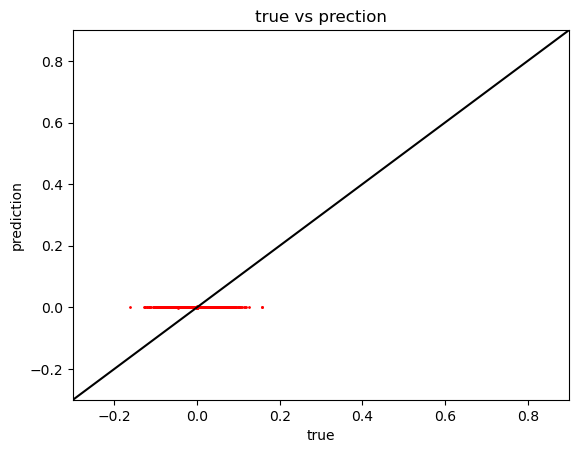

In [13]:
# 可视化
l_lim, r_lim = -0.3, 0.9
plt.figure()
plt.scatter(test_y, prediction, color='red', s=1)
plt.plot([l_lim, r_lim], [l_lim, r_lim], color='black', linestyle='-')
plt.xlim([l_lim, r_lim])
plt.ylim([l_lim, r_lim])
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('true vs prection')
plt.show()

In [14]:
# 打印参数
for _,param in enumerate(net.parameters()):
    print(param)
    print('----------------')

Parameter containing:
tensor([[-2.4838e-01,  6.7950e-01,  1.6349e-01, -2.6008e-01, -2.3420e-01,
         -3.7982e+00,  2.7617e-01,  1.8279e-02, -1.0783e-01,  1.7903e-01],
        [-1.4360e-01, -2.1413e+00,  2.0521e-01,  1.9728e-01, -2.1368e-01,
          1.0142e-01, -1.6323e-01,  1.7879e+00, -1.5069e+00,  3.1682e-01],
        [-1.3496e-01, -3.3246e-01,  8.5013e-02,  1.1990e-03, -1.0230e-01,
         -5.1138e-01,  1.3328e-01,  9.7189e-01, -5.1047e-01,  1.3344e+00],
        [ 5.8517e-01, -4.9537e-01,  1.0270e-01,  1.7831e-01, -7.9962e-02,
         -8.3554e-03,  2.6967e-01, -3.9827e+00,  1.5984e-01, -9.1328e-02],
        [ 1.8940e+00, -6.6488e-01,  3.9174e-01,  1.8925e-01, -2.2509e-01,
          8.2365e-02, -1.7679e-01, -1.0392e+00, -1.4440e-01,  1.5787e-01],
        [-5.3123e-01, -5.5579e-01, -1.8334e-01,  4.9233e-01, -1.5771e-01,
         -2.3024e-02, -4.8017e-01,  1.8038e+00, -4.1068e-01, -9.3522e-02],
        [ 3.4273e-01,  1.5379e-01, -2.5160e+00, -1.8905e-01, -1.4790e+00,
         -

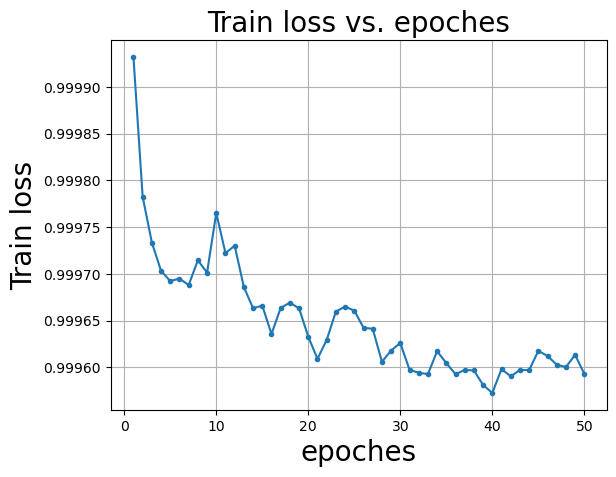

In [14]:
# 绘制train loss
plt.cla()
x1 = range(1, epochs + 1)
y1 = train_loss
plt.title('Train loss vs. epoches', fontsize=20)
plt.plot(x1, y1, '.-')
plt.xlabel('epoches', fontsize=20)
plt.ylabel('Train loss', fontsize=20)
plt.grid()
'''plt.savefig("./lossAndacc/Train_loss.png")
plt.savefig("./lossAndacc/Train_loss.png")'''
plt.show()

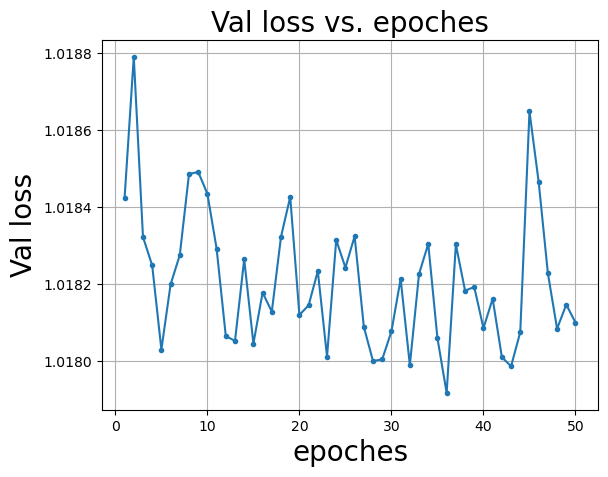

In [15]:
# 绘制val loss
plt.cla()
x1 = range(1, epochs+1)
y1 = val_loss
plt.title('Val loss vs. epoches', fontsize=20)
plt.plot(x1, y1, '.-')
plt.xlabel('epoches', fontsize=20)
plt.ylabel('Val loss', fontsize=20)
plt.grid()
'''plt.savefig("./lossAndacc/Train_loss.png")
plt.savefig("./lossAndacc/Train_loss.png")'''
plt.show()

In [16]:
# save & load the model

path = "./model/add"
file_name = "/sota_for_SGD.pkl"
torch.save(net, path + file_name)

'''
model = torch.load(path + file_name)
model.eval()
'''

'\nmodel = torch.load(path + file_name)\nmodel.eval()\n'